# Artificial Neural Networks & Hyperparameter Optimization

Data from: https://www.kaggle.com/datasets/gregorut/videogamesales

In [2]:
!pip install ann_visualizer
!pip install kaleido

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for ann_visualizer: filename=ann_visualizer-2.5-py3-none-any.whl size=4167 sha256=bf67c6c712d7ec6e851af0266b9de48a5a3c053657270c30594db8f9b966f3b5
  Stored in directory: /root/.cache/pip/wheels/6e/0f/ae/f5dba91db71b1b32bf03d0ad18c32e86126093aba5ec6b6488
Successfully built ann_visualizer
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 11.4 MB/s eta 0:00:00


## Setup

In [3]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
plt.rcParams['legend.fontsize'] = '16'

In [4]:
df = pd.read_csv('vgsales.csv')
df.head()

,Rank,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales
0,1,Wii Sports,Wii,2006.0,Sports,Nintendo,41.49,29.02,3.77,8.46,82.74
1,2,Super Mario Bros.,NES,1985.0,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24
2,3,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,15.85,12.88,3.79,3.31,35.82
3,4,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,15.75,11.01,3.28,2.96,33.00
4,5,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.37


In [5]:
percent_missing = df.isnull().sum() * 100 / len(df)
missing_values = pd.DataFrame({'column_name': df.columns,
                               'percent_missing': percent_missing})
missing_values

,column_name,percent_missing
Rank,Rank,0.000000
Name,Name,0.000000
Platform,Platform,0.000000
Year,Year,1.632727
Genre,Genre,0.000000
Publisher,Publisher,0.349440
NA_Sales,NA_Sales,0.000000
EU_Sales,EU_Sales,0.000000
JP_Sales,JP_Sales,0.000000
Other_Sales,Other_Sales,0.000000


In [6]:
df = df.dropna().drop(['Rank', 'Year'], axis=1).apply(LabelEncoder().fit_transform)
X = df.drop(['Genre'], axis=1)
y = df['Genre']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

## Artificial Neural Networks

In [7]:
from keras.models import Sequential
from keras.layers import Dense
from ann_visualizer.visualize import ann_viz

model = Sequential()
model.add(Dense(units=4,activation='relu',
                  input_dim=7))
model.add(Dense(units=4,activation='sigmoid'))
model.add(Dense(units=2,activation='relu'))

ann_viz(model, view=True, filename="example", title="Example ANN")

## Hyperparameter Optimization

In [8]:
from sklearn.model_selection import RandomizedSearchCV

random_search = {'max_depth': list(np.linspace(10, 1200, 10, dtype = int)) + [None],
               'min_samples_leaf': [4, 6, 8, 12],
               'min_samples_split': [5, 7, 10, 14],
               'max_leaf_nodes': list(np.linspace(10, 120, 10, dtype = int)),
               'n_estimators': list(np.linspace(151, 1200, 10, dtype = int)),
                 'bootstrap': [True, False]
                }

clf = RandomForestClassifier()
model = RandomizedSearchCV(estimator = clf, param_distributions = random_search, n_iter = 7, 
                               cv = 2, verbose= 5, random_state= 101, n_jobs = -1)
model.fit(X_train,y_train)

Fitting 2 folds for each of 7 candidates, totalling 14 fits


RandomizedSearchCV(cv=2, estimator=RandomForestClassifier(), n_iter=7,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 142, 274, 406, 538,
                                                      671, 803, 935, 1067, 1200,
                                                      None],
                                        'max_leaf_nodes': [10, 22, 34, 46, 58,
                                                           71, 83, 95, 107,
                                                           120],
                                        'min_samples_leaf': [4, 6, 8, 12],
                                        'min_samples_split': [5, 7, 10, 14],
                                        'n_estimators': [151, 267, 384, 500,
                                                         617, 733, 850, 966,
                                                         1083, 1200]},
                   random_state=101, verbose=5)

<Axes: xlabel='param_min_samples_leaf', ylabel='param_n_estimators'>

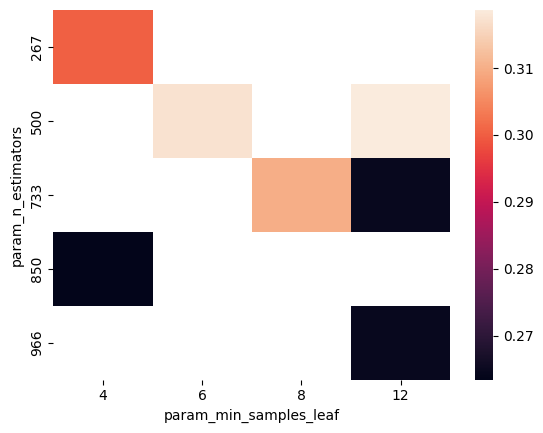

In [9]:
import seaborn as sns

table = pd.pivot_table(pd.DataFrame(model.cv_results_),
    values='mean_test_score', index='param_n_estimators', columns='param_min_samples_leaf')
     
sns.heatmap(table)

In [10]:
df2 = pd.DataFrame(model.cv_results_)
df2['param_bootstrap'] = LabelEncoder().fit_transform(df2['param_bootstrap'])
df2['mean_test_score'] = df2['mean_test_score']*100
df2 = df2[['param_bootstrap', 'param_n_estimators', 'param_min_samples_split', 
           'param_min_samples_leaf', 'param_max_leaf_nodes',
           'param_max_depth', 'mean_test_score']].astype(int)
df2.head()

,param_bootstrap,param_n_estimators,param_min_samples_split,param_min_samples_leaf,param_max_leaf_nodes,param_max_depth,mean_test_score
0,0,267,7,4,34,10,30
1,0,733,10,12,10,10,26
2,1,850,5,4,10,671,26
3,1,733,7,8,71,406,30
4,1,500,5,6,95,935,31


### Pandas

<Axes: title={'center': 'Parallel Coordinates Example'}>

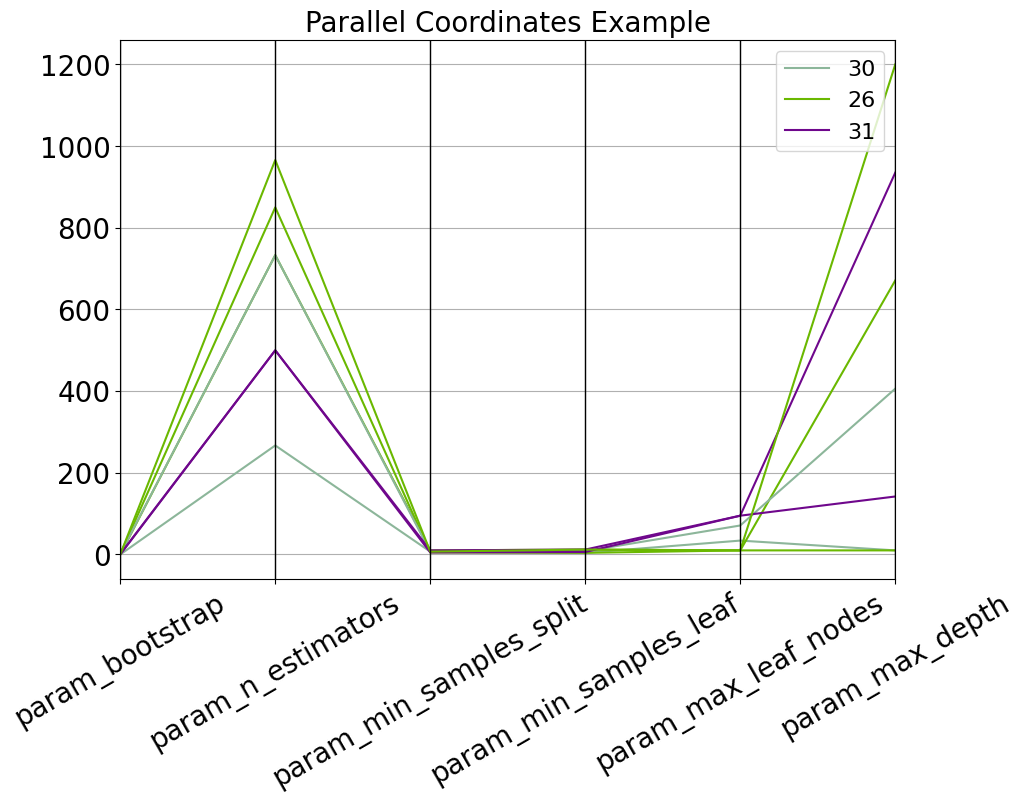

In [11]:
from pandas.plotting import parallel_coordinates

fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111)
ax.set_title("Parallel Coordinates Example", fontsize=20)
ax.tick_params(axis='x', rotation=30)
ax.tick_params(axis='both', labelsize=20)
parallel_coordinates(df2, class_column='mean_test_score', ax=ax)

### Yellowbrick

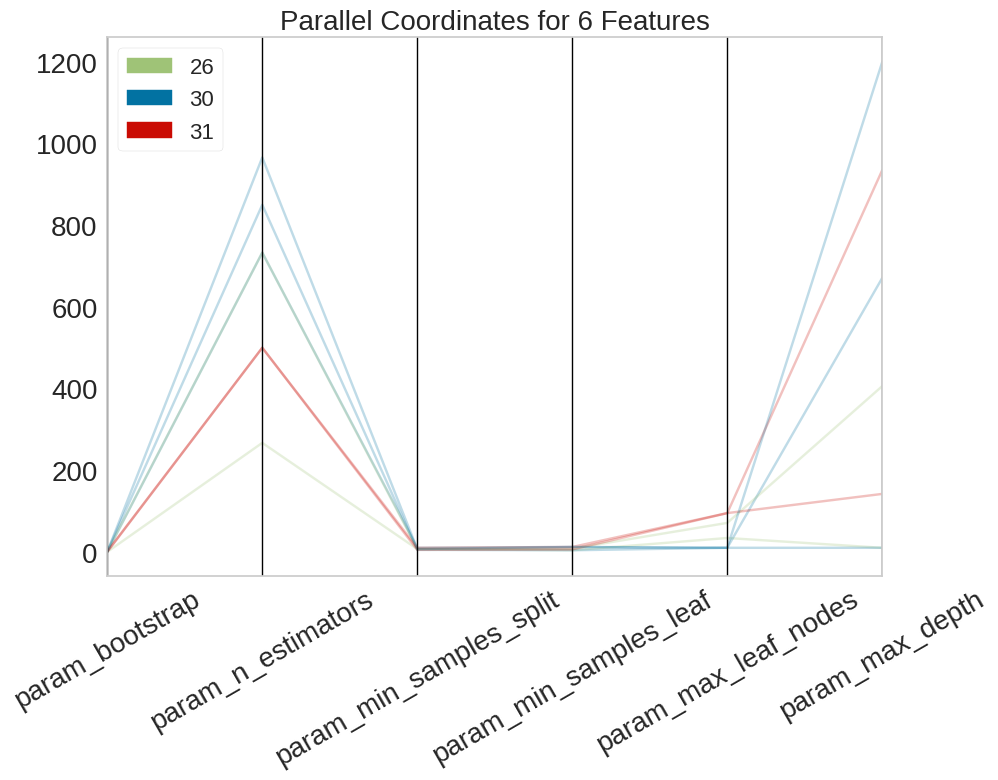

<Axes: title={'center': 'Parallel Coordinates for 6 Features'}>

In [12]:
from yellowbrick.features.pcoords import parallel_coordinates

# Specify the features of interest and the classes of the target
features = list(df2.drop('mean_test_score', axis=1).columns)
classes = list(df2['mean_test_score'].unique())

# Fit the visualizer and display it
plt.rcParams['legend.fontsize'] = '16'
plt.rcParams['axes.titlesize'] = '20'
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111)
ax.tick_params(axis='x', rotation=30)
ax.tick_params(axis='both', labelsize=20)

visualizer = parallel_coordinates(df2.drop('mean_test_score', axis=1), 
                                  df2['mean_test_score'], ax=ax, 
                                  classes=classes, features=features)
visualizer.show(fontsize=20)

### Custom Matplotlib

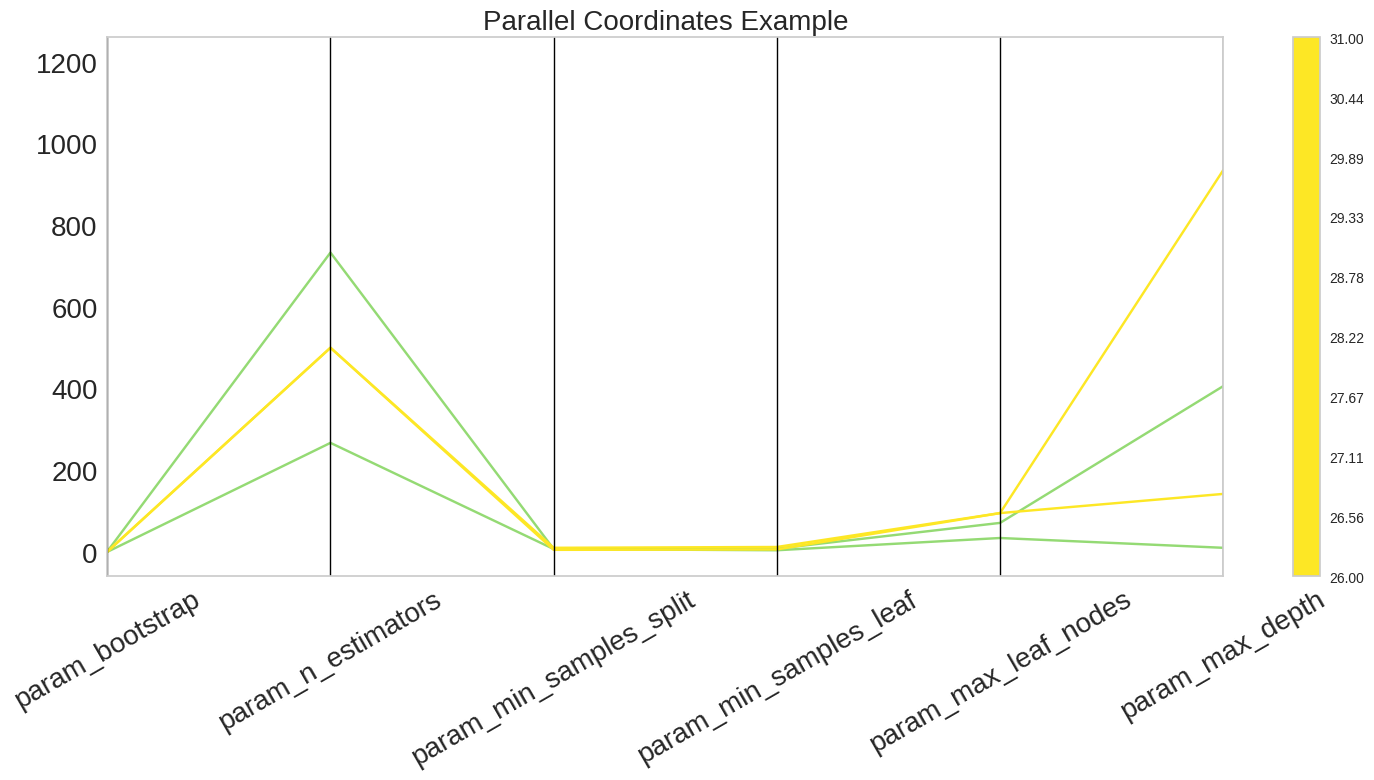

In [13]:
# From: https://stackoverflow.com/questions/23547347/parallel-coordinates-plot-for-continous-data-in-pandas
def parallel_coordinates2(frame, class_column, cols=None, ax=None, color=None,
                     use_columns=False, xticks=None, colormap=None,
                     **kwds):

    n = len(frame)
    class_col = frame[class_column]
    class_min = np.amin(class_col)
    class_max = np.amax(class_col)

    if cols is None:
        df = frame.drop(class_column, axis=1)
    else:
        df = frame[cols]

    used_legends = set([])

    ncols = len(df.columns)

    # determine values to use for xticks
    if use_columns is True:
        if not np.all(np.isreal(list(df.columns))):
            raise ValueError('Columns must be numeric to be used as xticks')
        x = df.columns
    elif xticks is not None:
        if not np.all(np.isreal(xticks)):
            raise ValueError('xticks specified must be numeric')
        elif len(xticks) != ncols:
            raise ValueError('Length of xticks must match number of columns')
        x = xticks
    else:
        x = range(ncols)

    fig = plt.figure(figsize=(18,7))
    ax = fig.add_subplot(111)

    Colorm = plt.get_cmap(colormap)

    for i in range(n):
        y = df.iloc[i].values
        kls = class_col.iat[i]
        ax.plot(x, y, color=Colorm((kls - class_min)/(class_max-class_min)), 
                alpha=(kls - class_min)/(class_max-class_min), **kwds)

    for i in x:
        ax.axvline(i, linewidth=1, color='black')

    ax.set_xticks(x)
    ax.set_xticklabels(df.columns)
    ax.set_xlim(x[0], x[-1])
    ax.set_title("Parallel Coordinates Example", fontsize=20)
    ax.tick_params(axis='x', rotation=30)
    ax.tick_params(axis='both', labelsize=20)
    ax.grid(False)

    bounds = np.linspace(class_min,class_max,10)
    cax,_ = mpl.colorbar.make_axes(ax)
    cb = mpl.colorbar.ColorbarBase(cax, cmap=Colorm, spacing='proportional', ticks=bounds, 
                                   boundaries=bounds, format='%.2f')

    return fig


fig = parallel_coordinates2(df2, class_column='mean_test_score',  colormap="viridis")

### Plotly

In [14]:
import plotly.express as px

fig = px.parallel_coordinates(df2, color="mean_test_score", 
                             labels=dict(zip(list(df2.columns), 
                                             list(['_'.join(i.split('_')[1:]) for i in df2.columns]))),
                             color_continuous_scale=px.colors.diverging.Tealrose)
fig.write_image("parallel_coordinates.svg")
fig.show()

# Exercises

1. Are you able to share the plotly express parallel coordinates plot online and embed it on the web using Plotly Chart Studio or Datapane? You can find [here an example](https://ppiconsulting.dev/blog/blog70/).
2. Can you create a parallel coordinates plot to inspect the relationship between the different features in the cleaned data frame?
